In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import pandas as pd
import numpy as np

from utils.preprocessing import preprocess_df
from utils.df_loader import load_adult_df, load_compas_df, load_german_df, load_diabetes_df, load_breast_cancer_df
from utils.evaluation import get_evaluations, EvaluationMatrix

from utils.load import load_result_from_csv, load_datapoints_from_npy
from utils.models import load_models
from utils.models import save_model_performance

seed = 42

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None # suppress "SettingWithCopyWarning" warning

In [32]:
datasets = [
        # "adult",
        # "german",
        # "compas",
        "diabetes",
        # "breast_cancer",
        ]

models = ["nn_2"] # "dt","gbc","lr","svc",

attack_list = []
for epsilon in [0.01, 0.03, 0.1, 0.2, 0.3, 0.5, 0.7, 1]:
    for epsilon_step in [0.01, 0.03, 0.1, 0.2]:
        attack_list.append(f"pgd_l_inf_{epsilon}_{epsilon_step}")
          



In [34]:
attack_list

['pgd_l_inf_0.01_0.01',
 'pgd_l_inf_0.01_0.03',
 'pgd_l_inf_0.01_0.1',
 'pgd_l_inf_0.01_0.2',
 'pgd_l_inf_0.03_0.01',
 'pgd_l_inf_0.03_0.03',
 'pgd_l_inf_0.03_0.1',
 'pgd_l_inf_0.03_0.2',
 'pgd_l_inf_0.1_0.01',
 'pgd_l_inf_0.1_0.03',
 'pgd_l_inf_0.1_0.1',
 'pgd_l_inf_0.1_0.2',
 'pgd_l_inf_0.2_0.01',
 'pgd_l_inf_0.2_0.03',
 'pgd_l_inf_0.2_0.1',
 'pgd_l_inf_0.2_0.2',
 'pgd_l_inf_0.3_0.01',
 'pgd_l_inf_0.3_0.03',
 'pgd_l_inf_0.3_0.1',
 'pgd_l_inf_0.3_0.2',
 'pgd_l_inf_0.5_0.01',
 'pgd_l_inf_0.5_0.03',
 'pgd_l_inf_0.5_0.1',
 'pgd_l_inf_0.5_0.2',
 'pgd_l_inf_0.7_0.01',
 'pgd_l_inf_0.7_0.03',
 'pgd_l_inf_0.7_0.1',
 'pgd_l_inf_0.7_0.2',
 'pgd_l_inf_1_0.01',
 'pgd_l_inf_1_0.03',
 'pgd_l_inf_1_0.1',
 'pgd_l_inf_1_0.2']

In [33]:
def get_loading_fn(dataset_name):
    if dataset_name == 'adult':
        dataset_loading_fn = load_adult_df
    elif dataset_name == 'german':
        dataset_loading_fn = load_german_df
    elif dataset_name == 'compas':
        dataset_loading_fn = load_compas_df
    elif dataset_name == 'diabetes':
        dataset_loading_fn = load_diabetes_df
    elif dataset_name == 'breast_cancer':
        dataset_loading_fn = load_breast_cancer_df
    else:
        raise Exception("Unsupported dataset")
    return dataset_loading_fn


## Combine dataframe

In [5]:
# for dataset_name in datasets:
#     for attack in attack_list:
#         folder_name = f"{attack}_{dataset_name}"

#         ## check if the folder exist

#         if os.path.isdir(f'./results/{folder_name}'):
#             for model_name in models:

#                 dfs = []
#                 file_name = f'{folder_name}_{model_name}_result.csv'
#                 destination_path = f'./results/{folder_name}/{file_name}'

#                 if os.path.isfile(f'./results/{folder_name}/{folder_name}_{model_name}_result_1.csv'):
#                     for i in range(0,10):
#                         dataset_path = (
#                             f"{attack}_{dataset_name}_{model_name}_result_{i}.csv"
#                         )
#                         dfs.append(pd.read_csv(f"./results/{folder_name}/{dataset_path}"))

#                     ### Combine dfs
#                     complete_df = pd.DataFrame([], columns=dfs[0].columns)
#                     for l in range(len(dfs[0])):
#                         for df in dfs:
#                             complete_df = complete_df.append(df.iloc[l : l + 1])

#                     ### Save dfs
#                     complete_df.to_csv(destination_path)
#                     print(f"Have saved combined sheet to {destination_path}")

## Check wheather white-box attack output same results

In [6]:
# def are_ndarrays_same(ndarrays):
#   # Create an empty matrix of size len(ndarrays) x len(ndarrays)
#   results_matrix = np.empty((len(ndarrays), len(ndarrays)))

#   # Iterate through each pair of ndarrays and check if they are the same
#   for i in range(len(ndarrays)):
#     for j in range(len(ndarrays)):
#       if i == j:
#         # If the indices are the same, mark it as True in the results matrix
#         results_matrix[i][j] = True
#       else:
#         # Compare the ndarrays using the numpy.array_equal function
#         results_matrix[i][j] = np.array_equal(ndarrays[i], ndarrays[j])
#   return results_matrix

In [7]:
# for dataset_name in datasets:
#     for attack in attack_list:
#         for model_name in models:
#             ndarrays = []
#             for running_times in range(0,10):
#                 ndarrays.append(load_datapoints_from_npy(attack, dataset_name, model_name, running_times, adv=True))
#             print(f'{dataset_name} - {attack} - {model_name}')
#             print(are_ndarrays_same(ndarrays).min())




## Evaluation

In [35]:
def get_dic_from_metric(all_metric):

    dataset_arr = []
    attack_arr = []
    model_arr = []
    metric_arr = []
    value_arr = []

    for dataset, dic1 in all_metric.items():
        for attack, dic2 in dic1.items():
            for model, dic3 in dic2.items():
                for metric, value in dic3.items():
                    dataset_arr.append(dataset)
                    attack_arr.append(attack)
                    model_arr.append(model)
                    metric_arr.append(metric)
                    value_arr.append(value)

    table = {
            'Dataset': dataset_arr,
            'Attack': attack_arr,
            'Model': model_arr,
            'Metric': metric_arr,
            'Value': value_arr,
        }

    return table




In [36]:
#### Select dataset ####

all_metric = {}

for dataset_name in datasets:
    all_metric[dataset_name]={}

    df_info = preprocess_df(get_loading_fn(dataset_name))
    for attack in attack_list:
        all_metric[dataset_name][attack]={}

        folder_name = f'{attack}_{dataset_name}'
        for model_name in models:

            file_name = f'{folder_name}_{model_name}_result_1.csv'
            result_path = f'./results/{folder_name}/{file_name}'
            if os.path.isfile(result_path):
                result_df = pd.read_csv(result_path)
                evaluation_df, metric = get_evaluations(result_df=result_df, 
                    df_info=df_info, 
                    matrix = [
                        EvaluationMatrix.L1, 
                        EvaluationMatrix.L2, 
                        EvaluationMatrix.Linf,
                        EvaluationMatrix.Sen, 
                        EvaluationMatrix.Mahalanobis,
                        EvaluationMatrix.Sparsity, 
                        ])
                
                all_metric[dataset_name][attack][model_name] = metric

                csv_save_result_path = f'results/{folder_name}/eval_{file_name}'
                evaluation_df.to_csv(csv_save_result_path)
                print(f"Have saved file to {csv_save_result_path}")


Have saved file to results/pgd_l_inf_0.01_0.01_diabetes/eval_pgd_l_inf_0.01_0.01_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.01_0.03_diabetes/eval_pgd_l_inf_0.01_0.03_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.01_0.1_diabetes/eval_pgd_l_inf_0.01_0.1_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.01_0.2_diabetes/eval_pgd_l_inf_0.01_0.2_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.03_0.01_diabetes/eval_pgd_l_inf_0.03_0.01_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.03_0.03_diabetes/eval_pgd_l_inf_0.03_0.03_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.03_0.1_diabetes/eval_pgd_l_inf_0.03_0.1_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.03_0.2_diabetes/eval_pgd_l_inf_0.03_0.2_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0.1_0.01_diabetes/eval_pgd_l_inf_0.1_0.01_diabetes_nn_2_result_1.csv
Have saved file to results/pgd_l_inf_0

In [37]:
im_results = pd.DataFrame.from_dict(get_dic_from_metric(all_metric))

In [38]:
# im_results.to_csv(f"./results/{datasets[0]}_evaluation_results.csv",index=False)
# im_results.to_csv(f"./results/diabetes_evaluation_results.csv",index=False)
# im_results.to_csv(f"./results/carlini_l2_adult_table.csv",index=False)
im_results.to_csv(f"./results/{datasets[0]}_PGD_pareto_front_imp.csv",index=False)

In [39]:
im_results = pd.read_csv(f"./results/{datasets[0]}_PGD_pareto_front_imp.csv")


In [43]:

title_list = ["Dataset", "Attack", "Model"] + list(im_results.iloc[0:6,3])

all_eva = []
for dataset in datasets:
    im_results = pd.read_csv(f"./results/{datasets[0]}_PGD_pareto_front_imp.csv")


    for m in range(0,im_results.shape[0],6):

        data_list = list(im_results.iloc[m,0:3]) + list(im_results.iloc[m:m+6,4])
        all_eva.append(data_list)

df_all_eva = pd.DataFrame(all_eva,columns=title_list)

df_all_eva.Dataset = df_all_eva.Dataset.astype("category")
df_all_eva.Dataset = df_all_eva.Dataset.cat.set_categories(datasets)
df_all_eva.Model = df_all_eva.Model.astype("category")
df_all_eva.Model = df_all_eva.Model.cat.set_categories(models)
df_all_eva.Attack = df_all_eva.Attack.astype("category")
df_all_eva.Attack = df_all_eva.Attack.cat.set_categories(attack_list)

df_all_eva = df_all_eva.sort_values(by=["Dataset", "Model", "Attack", ])

In [41]:
# df_all_eva.to_csv(f"./results/all_evaluation_results.csv",index=False)

In [44]:
df_all_eva

,Dataset,Attack,Model,eval_L1,eval_L2,eval_Linf,eval_Sen,eval_Mahalanobis,eval_Sparsity
0,diabetes,pgd_l_inf_0.01_0.01,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
1,diabetes,pgd_l_inf_0.01_0.03,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
2,diabetes,pgd_l_inf_0.01_0.1,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
3,diabetes,pgd_l_inf_0.01_0.2,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
4,diabetes,pgd_l_inf_0.03_0.01,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
5,diabetes,pgd_l_inf_0.03_0.03,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
6,diabetes,pgd_l_inf_0.03_0.1,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
7,diabetes,pgd_l_inf_0.03_0.2,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
8,diabetes,pgd_l_inf_0.1_0.01,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625
9,diabetes,pgd_l_inf_0.1_0.03,nn_2,2.188932,0.799918,0.3,1.769111,0.149222,7.625


## Model Performance

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def compare_ndarrays(arr1, arr2):
    if arr1.shape != arr2.shape:
        raise ValueError("Input arrays have different shapes")
    return np.where(arr1 == arr2, 0, 1)

def get_attack_success_accuracy(models, model, input_array, adv_array, groundtruth):

    if model == 'dt':
        predictions = models['dt'].predict(input_array)
        adv_predictions = models['dt'].predict(adv_array)
    if model == 'rfc':
        predictions = models['rfc'].predict(input_array)
        adv_predictions = models['rfc'].predict(adv_array)
    if model == 'svc':
        predictions = models['svc'].predict(input_array)
        adv_predictions = models['svc'].predict(adv_array)
    if model == 'lr':
        predictions = models['lr'].predict(input_array)
        adv_predictions = models['lr'].predict(adv_array)
    if model == 'gbc':
        predictions = models['gbc'].predict(input_array)
        adv_predictions = models['gbc'].predict(adv_array)
    if model == 'nn':
        predictions = (models['nn'].predict(input_array) > 0.5).flatten().astype(int)
        adv_predictions = (models['nn'].predict(adv_array) > 0.5).flatten().astype(int)
    if model == 'nn_2':
        predictions = models['nn_2'].predict(input_array).argmax(axis=1).flatten().astype(int)
        adv_predictions = models['nn_2'].predict(adv_array).argmax(axis=1).flatten().astype(int)


    pred_attack_success = compare_ndarrays(predictions, adv_predictions).mean()
    groundtruth_attack_success = compare_ndarrays(groundtruth, adv_predictions).mean()
    original_accuracy = accuracy_score(groundtruth, predictions)
    robust_accuracy = accuracy_score(groundtruth, adv_predictions)



    dict = {
        'groundtruth_attack_success': groundtruth_attack_success,
        'pred_attack_success':pred_attack_success, 
            'original_accuracy': original_accuracy, 
            'robust_accuracy': robust_accuracy}

    print(dict)
    return dict



In [17]:
# from utils.models import save_model_performance

In [18]:
#### Select dataset ####

all_performance = {}

for dataset_name in datasets:
    all_performance[dataset_name]={}

    df_info = preprocess_df(get_loading_fn(dataset_name))
    train_df, test_df = train_test_split(
        df_info.dummy_df, train_size=0.8, random_state=seed, shuffle=True
    )
    X_train = np.array(train_df[df_info.ohe_feature_names])
    y_train = np.array(train_df[df_info.target_name])
    X_test = np.array(test_df[df_info.ohe_feature_names])
    y_test = np.array(test_df[df_info.target_name])

    X_test_num = len(X_test) - (len(X_test)%64)
    X_test_re=X_test[0:X_test_num]
    y_test_num = len(y_test) - (len(y_test)%64)
    y_test_re=y_test[0:y_test_num]

    predict_model = load_models(X_train.shape[-1], dataset_name)

    for attack in attack_list:
        all_performance[dataset_name][attack]={}

        folder_name = f'{attack}_{dataset_name}'
        for model_name in models:

            adv_arr_name = f'{folder_name}_{model_name}_arr_adv_1.npy'
            adv_arr_path = f'./datapoints/{folder_name}/{adv_arr_name}'
            
            if os.path.isfile(adv_arr_path):
                adv_arr = load_datapoints_from_npy(attack, dataset_name, model_name, 1, adv=True)

                all_performance[dataset_name][attack][model_name] = get_attack_success_accuracy(predict_model, model_name, X_test_re, adv_arr, y_test_re)

                # m = save_model_performance(predict_model,dataset_name, adv_arr, y_test_re)



1/1 [==============================] - 0s 45ms/step
{'groundtruth_attack_success': 0.234375, 'pred_attack_success': 0.1015625, 'original_accuracy': 0.7578125, 'robust_accuracy': 0.765625}
{'groundtruth_attack_success': 0.265625, 'pred_attack_success': 0.1015625, 'original_accuracy': 0.7578125, 'robust_accuracy': 0.734375}
4/4 [==============================] - 0s 1ms/step
{'groundtruth_attack_success': 0.2578125, 'pred_attack_success': 0.078125, 'original_accuracy': 0.7265625, 'robust_accuracy': 0.7421875}
{'groundtruth_attack_success': 0.2734375, 'pred_attack_success': 0.203125, 'original_accuracy': 0.7578125, 'robust_accuracy': 0.7265625}
{'groundtruth_attack_success': 0.2890625, 'pred_attack_success': 0.21875, 'original_accuracy': 0.7578125, 'robust_accuracy': 0.7109375}
4/4 [==============================] - 0s 1ms/step
{'groundtruth_attack_success': 0.2578125, 'pred_attack_success': 0.28125, 'original_accuracy': 0.7265625, 'robust_accuracy': 0.7421875}
{'groundtruth_attack_success

In [19]:

performance_df = pd.DataFrame.from_dict(get_dic_from_metric(all_performance))


In [20]:
performance_df.to_csv(f"./results/{datasets[0]}_FGSM_Pareto_Front_Performance.csv",index=False)

In [11]:
performance_df = pd.read_csv(f"./results/{datasets[0]}_FGSM_Pareto_Front_Performance.csv")

In [19]:
# select rows based on condition - Metric == 'groundtruth_attack_success'
performance_df[performance_df['Metric'] == 'groundtruth_attack_success'][performance_df['Model'] == 'nn_2']


C:\Users\n10599070\AppData\Local\Temp\ipykernel_27516\845103212.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  performance_df[performance_df['Metric'] == 'groundtruth_attack_success'][performance_df['Model'] == 'nn_2']


,Dataset,Attack,Model,Metric,Value
8,diabetes,fgsm_l_inf_0.01,nn_2,groundtruth_attack_success,0.257812
20,diabetes,fgsm_l_inf_0.03,nn_2,groundtruth_attack_success,0.257812
32,diabetes,fgsm_l_inf_0.1,nn_2,groundtruth_attack_success,0.476562
44,diabetes,fgsm_l_inf_0.2,nn_2,groundtruth_attack_success,0.726562
56,diabetes,fgsm_l_inf_0.3,nn_2,groundtruth_attack_success,0.726562
68,diabetes,fgsm_l_inf_0.5,nn_2,groundtruth_attack_success,0.726562
80,diabetes,fgsm_l_inf_0.7,nn_2,groundtruth_attack_success,0.726562
92,diabetes,fgsm_l_inf_1,nn_2,groundtruth_attack_success,0.726562


In [26]:
attack_success_rates = performance_df[performance_df['Metric'] == 'groundtruth_attack_success'][performance_df['Model'] == 'nn_2']['Value'].to_list()

C:\Users\n10599070\AppData\Local\Temp\ipykernel_27516\3629200456.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  attack_success_rates = performance_df[performance_df['Metric'] == 'groundtruth_attack_success'][performance_df['Model'] == 'nn_2']['Value'].to_list()


[0.2578125,
 0.2578125,
 0.4765625,
 0.7265625,
 0.7265625,
 0.7265625,
 0.7265625,
 0.7265625]

In [20]:
df_all_eva[df_all_eva['Model'] == 'nn_2']

,Dataset,Attack,Model,eval_L1,eval_L2,eval_Linf,eval_Sen,eval_Mahalanobis,eval_Sparsity
2,diabetes,fgsm_l_inf_0.01,nn_2,0.075391,0.027418,0.010000,0.060962,0.005072,7.539062
5,diabetes,fgsm_l_inf_0.03,nn_2,0.226080,0.082220,0.030000,0.182805,0.015212,7.539062
8,diabetes,fgsm_l_inf_0.1,nn_2,0.747235,0.272212,0.100000,0.603964,0.050372,7.539062
11,diabetes,fgsm_l_inf_0.2,nn_2,1.471830,0.538277,0.200000,1.189559,0.099476,7.539062
14,diabetes,fgsm_l_inf_0.3,nn_2,2.160050,0.793898,0.300000,1.746372,0.146321,7.539062
17,diabetes,fgsm_l_inf_0.5,nn_2,3.341300,1.244214,0.500000,2.704436,0.229308,7.539062
20,diabetes,fgsm_l_inf_0.7,nn_2,4.122671,1.560890,0.694301,3.320857,0.292094,7.539062
23,diabetes,fgsm_l_inf_1,nn_2,4.704888,1.821767,0.924285,3.776934,0.345207,7.539062


In [24]:
l2 = df_all_eva[df_all_eva['Model'] == 'nn_2']['eval_L2'].to_list()

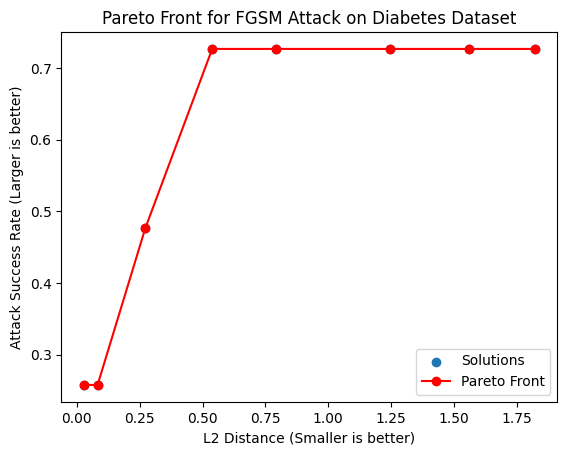

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Your data

# Convert lists to a numpy array with two columns (x, y)
points = np.column_stack((l2, attack_success_rates))

# Function to find Pareto front considering x smaller is better and y larger is better
def pareto_front(points):
    is_pareto = np.ones(points.shape[0], dtype=bool)  # Initialize a boolean array
    for i, point in enumerate(points):
        # A point is Pareto optimal if no other points have both:
        # - A smaller x value (better)
        # - A larger y value (better)
        is_pareto[i] = np.all(np.any((points[:, 0] >= point[0]) & (points[:, 1] <= point[1]), axis=0))
    return points[is_pareto]

# Find the Pareto front from the points
pareto_points = pareto_front(points)

# Sort Pareto front for better visualization
pareto_points = pareto_points[pareto_points[:, 0].argsort()]

# Plot all points
plt.scatter(l2, attack_success_rates, label="Solutions")

# Plot Pareto front
plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='red', marker='o', label="Pareto Front")

# Labels and legend
plt.title('Pareto Front for FGSM Attack on Diabetes Dataset')
plt.xlabel('L2 Distance (Smaller is better)')
plt.ylabel('Attack Success Rate (Larger is better)')
plt.legend()

# Show plot
plt.show()


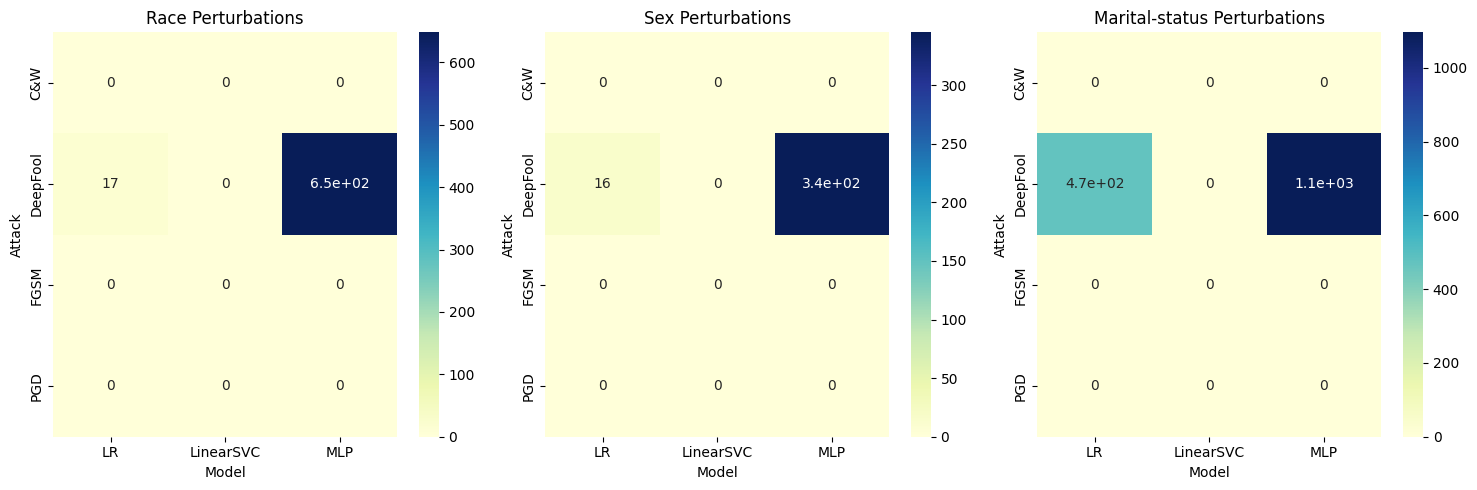

In [47]:
import seaborn as sns
import pandas as pd

# Prepare data for heatmap
data = {
    'Attack': ['DeepFool', 'C&W', 'FGSM', 'PGD'] * 3,
    'Model': ['LR'] * 4 + ['LinearSVC'] * 4 + ['MLP'] * 4,
    'race': [17, 0, 0, 0, 0, 0, 0, 0, 648, 0, 0, 0],
    'sex': [16, 0, 0, 0, 0, 0, 0, 0, 345, 0, 0, 0],
    'marital-status': [472, 0, 0, 0, 0, 0, 0, 0, 1096, 0, 0, 0],
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Create a heatmap for each feature
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Race heatmap
sns.heatmap(df.pivot('Attack', 'Model', 'race'), annot=True, cmap="YlGnBu", ax=ax[0])
ax[0].set_title('Race Perturbations')

# Sex heatmap
sns.heatmap(df.pivot('Attack', 'Model', 'sex'), annot=True, cmap="YlGnBu", ax=ax[1])
ax[1].set_title('Sex Perturbations')

# Marital-status heatmap
sns.heatmap(df.pivot('Attack', 'Model', 'marital-status'), annot=True, cmap="YlGnBu", ax=ax[2])
ax[2].set_title('Marital-status Perturbations')

plt.tight_layout()
plt.show()


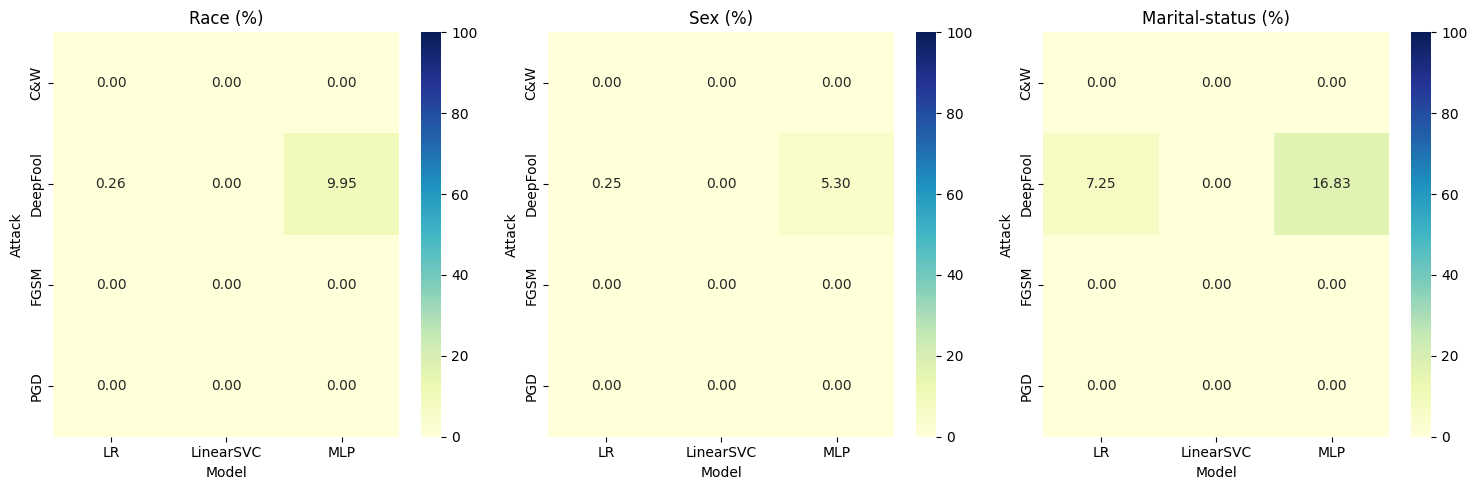

In [50]:
# Total adversarial examples generated per feature
total_adversarial = 6513

# Converting values to percentages for heatmap
data_percentage = {
    'Attack': ['DeepFool', 'C&W', 'FGSM', 'PGD'] * 3,
    'Model': ['LR'] * 4 + ['LinearSVC'] * 4 + ['MLP'] * 4,
    'race': [(v / total_adversarial) * 100 for v in [17, 0, 0, 0, 0, 0, 0, 0, 648, 0, 0, 0]],
    'sex': [(v / total_adversarial) * 100 for v in [16, 0, 0, 0, 0, 0, 0, 0, 345, 0, 0, 0]],
    'marital-status': [(v / total_adversarial) * 100 for v in [472, 0, 0, 0, 0, 0, 0, 0, 1096, 0, 0, 0]],
}

# Convert the data into a DataFrame
df_percentage = pd.DataFrame(data_percentage)

# Create a heatmap for each feature with percentage values
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Race heatmap with percentage
sns.heatmap(df_percentage.pivot('Attack', 'Model', 'race'), annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[0], vmin=0, vmax=100)
ax[0].set_title('Race (%)')

# Sex heatmap with percentage
sns.heatmap(df_percentage.pivot('Attack', 'Model', 'sex'), annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[1], vmin=0, vmax=100)
ax[1].set_title('Sex (%)')

# Marital-status heatmap with percentage
sns.heatmap(df_percentage.pivot('Attack', 'Model', 'marital-status'), annot=True, fmt=".2f", cmap="YlGnBu", ax=ax[2], vmin=0, vmax=100)
ax[2].set_title('Marital-status (%)')

plt.tight_layout()
plt.show()
